# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [1]:
# pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-io matplotlib

## 1.2 Load Dependencies

In [8]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow.io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [9]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [13]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    return wav


## 2.3 Plot Wave

In [14]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

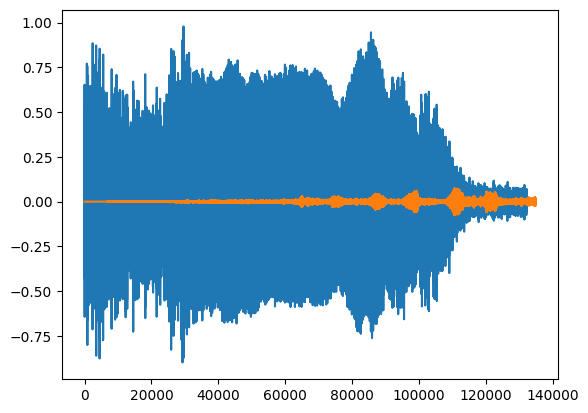

In [15]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [16]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [17]:
POS

'data/Parsed_Capuchinbird_Clips'

In [18]:
NEG

'data/Parsed_Not_Capuchinbird_Clips'

## 3.2 Create Tensorflow Datasets

In [19]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [20]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC216010-7.wav'

## 3.3 Add labels and Combine Positive and Negative Samples

In [21]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [22]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [23]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=149905>

In [24]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=22050>

In [25]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=220500>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [26]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [27]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [28]:
spectrogram, label = preprocess(filepath, label)

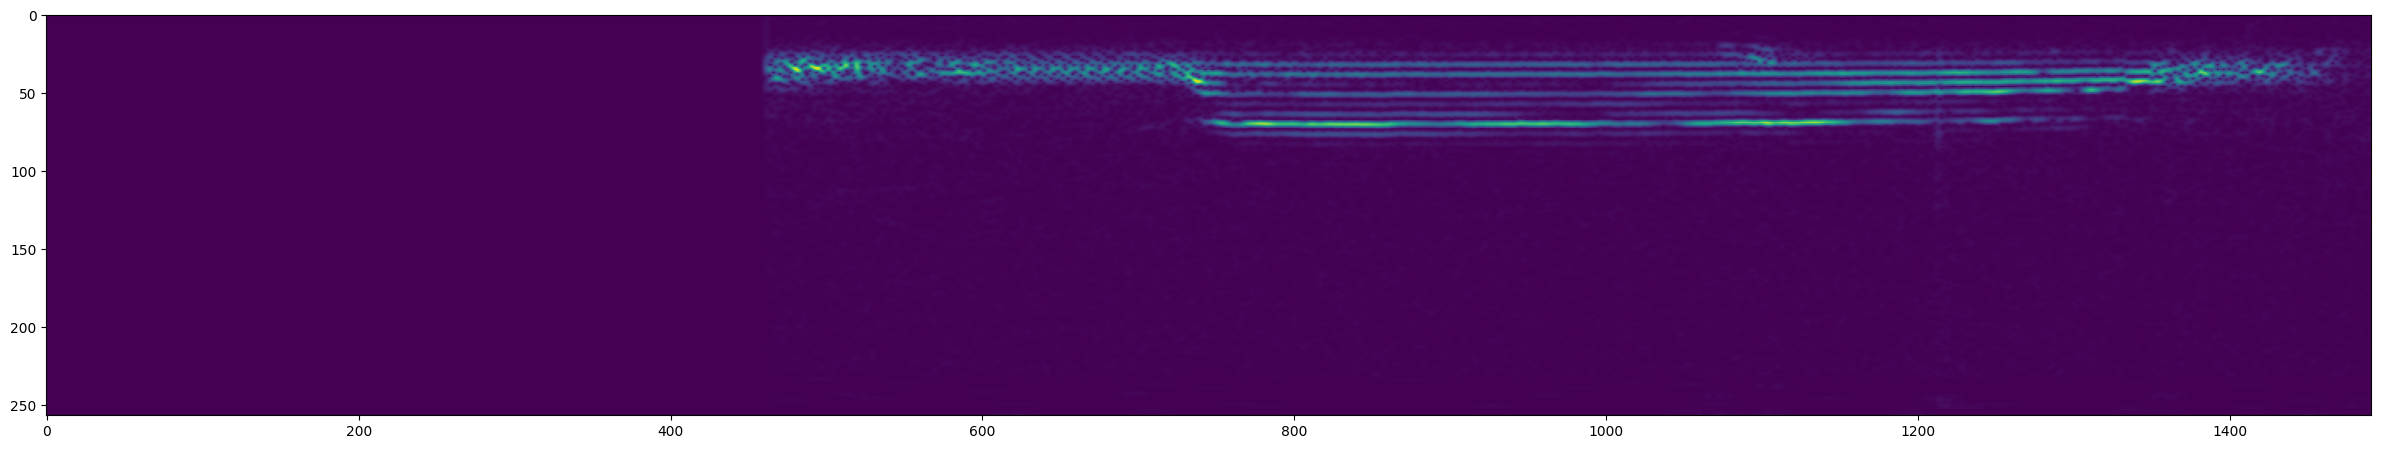

In [29]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [30]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [31]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [32]:
samples, labels = train.as_numpy_iterator().next()

In [33]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## 7.2 Build Sequential Model, Compile and View Summary

In [46]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [47]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [48]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 744, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 742, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 371, 62, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 368032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    47,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,110,833 (179.71 MB)

 Trainable params: 47,110,833 (179.71 MB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Fit Model, View Loss and KPI Plots

In [50]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2024-05-10 13:34:23.514853: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-05-10 13:34:23.514944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
	 [[{{function_node __inference_one_step_on_data_7782}}{{node sequential_3_1/flatten_2_1/Reshape}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_3_1/flatten_2_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_33931/2767293846.py", line 1, in <module>

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/models/functional.py", line 202, in call

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/models/functional.py", line 592, in call

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 4415, in reshape

  File "/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1778, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_3_1/flatten_2_1/Reshape}}]] [Op:__inference_one_step_on_iterator_7853]

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])